In [1]:
import pandas as pd
import os
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# df = pd.read_csv('AnnotatedDocuments - Cases.tsv', sep='\t')
df = pd.read_csv('AnnotatedDocumentsMyEdits.tsv', sep='\t')
df.set_index('Case Name',inplace=True)
df.head(2)

,Offence_final,Offence,Outcome: SM,Outcome: Overall Verdict,Support,Prior case Influence,Platform,Evidence Type,Unnamed: 9
Case Name,,,,,,,,,
People v Wells,murder,Murder in the second degree; criminal possessi...,"However, the admission of the photographs was ...",Judgement is affirmed,We agree with the Supreme Court's determinatio...,People v Price ; People v Patterson; People v ...,Facebook; Instagram,Photographs,NaN
Pecile v Titan Capital Group,sexual harassment,sexual harassment,Regarding defendants' demand for access to pla...,NaN,NaN,"Tapp v New York State Urban Dev. Corp.,",Social media,Posts,NaN


In [3]:
a= pd.DataFrame(df['Prior case Influence'].str.strip().str.lower().str.split(';').dropna().tolist(), 
                index=df['Prior case Influence'].str.strip().str.lower().str.split(';').dropna().index)
for col in a.columns:
    a[col]=a[col].str.strip(',.')
    a[col]=a[col].str.strip()
    
len(a.loc[:,0].reset_index())

35

In [6]:
final = a.loc[:,0].reset_index()
final.columns = ['source','target']
for col in [1,2,3,4,5]:
    b = a.loc[:,col].reset_index()
    b.columns = ['source','target']
    final= pd.concat([final,b],axis=0)
final.replace('', np.nan, regex=True, inplace=True)
final.dropna(inplace=True)
print(len(final))
final['source']=final['source'].str.lower()
final['source']=final['source'].str.replace('.','')
final['target']=final['target'].str.replace('.','')
for col in final.columns:
    final[col]=final[col].str.strip()
final.head()

101


,source,target
0,people v wells,people v price
1,pecile v titan capital group,tapp v new york state urban dev corp
2,people v wilson,people v rodriguez
3,people v wright,people v james
4,people v jackson,people v rose & people v valencia


## General properties

In [10]:
edges = [tuple(e) for e in final.values]
node_names = np.unique(list(final['source'].unique())+list(final['target'].unique()))

# Print the number of nodes and edges in our two lists
print(len(node_names))  
print(len(edges))                                                                               
import networkx as nx
G = nx.DiGraph() # Initialize a Graph object                                                        
G.add_nodes_from(node_names) # Add nodes to the Graph                             
G.add_edges_from(edges) # Add edges to the Graph  
print(nx.info(G)) # Print information about the Graph  

# average number of connections of each node in your network - avg degree

125
101
Name: 
Type: DiGraph
Number of nodes: 125
Number of edges: 101
Average in degree:   0.8080
Average out degree:   0.8080


In [11]:
# df['Prior case Influence']
final.groupby('source')['target'].unique()[:5]
# len(final.source.unique())

source
matter of kellogg v ny s board of parole     [matter of silmon v travis, phillips v dennison]
matter of tinsley v taxi                    [matter of acosta v new york city dept of educ...
pecile v titan capital group                           [tapp v new york state urban dev corp]
people v arnold                             [people v zaborski, people v clarke, people v ...
people v ashley                             [people v letterlough, matter of melissa b, ma...
Name: target, dtype: object

In [8]:
# df.reset_index()[['Case Name','Prior case Influence']].dropna()#.loc[df.index=='Pecile v Titan Capital Group','Prior case Influence']#.values

In [12]:
density = nx.density(G)
print("Network density:", density)
# sparse network

Network density: 0.006516129032258064


In [121]:
fell_whitehead_path = nx.shortest_path(G.to_undirected(), source="people v spears", target="people v scaringe")
# fell_whitehead_path = nx.shortest_path(G, target="people v wells", source="people v price")

print("Shortest path between wells and patterson:", fell_whitehead_path)
print("Length of that path:", len(fell_whitehead_path)-1)

Shortest path between wells and patterson: ['people v spears', 'people v romero', 'people v scaringe']
Length of that path: 2


//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure

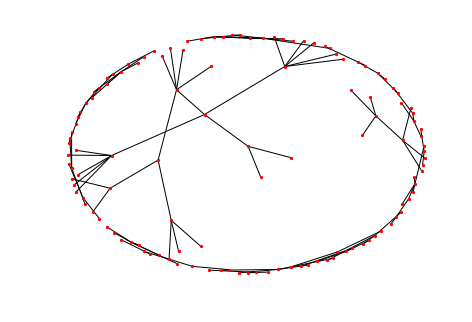

In [117]:
nx.draw_spring(G.to_undirected(), node_size=5,scale=2)

In [128]:
indegree_dict = G.in_degree(G.nodes())
import operator
sorted(indegree_dict.items(), 
       key=operator.itemgetter(1), reverse=True)

[('people v romero', 4),
 ('people v bleakley', 3),
 ('people v williams', 3),
 ('people v edmonson', 2),
 ('people v lynes', 2),
 ('davis v alaska', 1),
 ('fawcett v altieri', 1),
 ('lorraine v markel', 1),
 ('matter of acosta v new york city dept of education', 1),
 ('matter of colby', 1),
 ('matter of melissa b', 1),
 ('matter of silmon v travis', 1),
 ('matter of smith v devane', 1),
 ('matter of stephone', 1),
 ('matton v us', 1),
 ('north carolina v alford', 1),
 ('people v agina', 1),
 ('people v agudelo', 1),
 ('people v armstrong', 1),
 ('people v arnold', 1),
 ('people v ashley', 1),
 ('people v belile', 1),
 ('people v benevento', 1),
 ('people v bigelow', 1),
 ('people v boddie', 1),
 ('people v brown', 1),
 ('people v chambers', 1),
 ('people v clarke', 1),
 ('people v combest', 1),
 ('people v contes', 1),
 ('people v corby', 1),
 ('people v crimmins', 1),
 ('people v daiboch', 1),
 ('people v danielson', 1),
 ('people v darby', 1),
 ('people v de lucia', 1),
 ('people v 

In [129]:
outdegree_dict = G.out_degree(G.nodes())
import operator
sorted(outdegree_dict.items(), 
       key=operator.itemgetter(1), reverse=True)

[('people v arnold', 6),
 ('people v scaringe', 6),
 ('people v simonetta', 6),
 ('people v spears', 6),
 ('people v kasckarow', 5),
 ('people v russell', 5),
 ('people v wells', 5),
 ('people v mcevoy', 4),
 ('people v parris', 4),
 ('people v vanness', 4),
 ('united states v farrad', 4),
 ('people v ashley', 3),
 ('people v kent', 3),
 ('people v lenihan', 3),
 ('people v moxley', 3),
 ('people v sanders', 3),
 ('people v shortell', 3),
 ('people v stanislous', 3),
 ('matter of kellogg v ny s board of parole', 2),
 ('people v bonie', 2),
 ('people v clevenstine', 2),
 ('people v halter', 2),
 ('people v jamison', 2),
 ('people v pollard', 2),
 ('people v santana', 2),
 ("st paul's sch of nursing, inc v papaspiridakos", 2),
 ('matter of tinsley v taxi', 1),
 ('pecile v titan capital group', 1),
 ('people v jackson', 1),
 ('people v moye', 1),
 ('people v munck', 1),
 ('people v ramsaran', 1),
 ('people v santiago', 1),
 ('people v wilson', 1),
 ('people v wright', 1),
 ('davis v alask

In [134]:
final.groupby('source')['target'].nunique().mean()

2.8857142857142857

In [139]:
# df.loc[]
most_ref = [k for k in outdegree_dict.keys() if outdegree_dict[k]>=5]
df.loc[df['Case Name'].isin(most_ref)]

,index,Case Name,Offence_final,Offence,Outcome: SM,Outcome: Overall Verdict,Support,Prior case Influence,Platform,Evidence Type,Unnamed: 9
0,0,people v wells,murder,Murder in the second degree; criminal possessi...,"However, the admission of the photographs was ...",Judgement is affirmed,We agree with the Supreme Court's determinatio...,People v Price ; People v Patterson; People v ...,Facebook; Instagram,photographs,NaN
21,21,people v arnold,sexual assault,"Sexual act in the second degree (two counts), ...",True inffective assistance throughout trial,Convicted on all counts but defendants seeks t...,Testimonies of partner and sister; the fact th...,People v Zaborski; People v Clarke; People v B...,Web,emails,NaN
28,28,people v kasckarow,sexual assault,Sex offender; indecent assault (sexual battery...,NaN,Sexual offender probation for four years but t...,"SORA; For NYC, a nolo contendere plea is gener...",Matter of Smith v Devane; People v Daiboch; No...,NaN,NaN,NaN
30,30,people v spears,murder,"murder in the second degree, manslaughter in t...",It contradicted the evidence from physicians t...,The sentence imposed was not excessive; senten...,The clear establishment that the defendant int...,People v Contes; People v Danielson; People v ...,Facebook,photographs,NaN
31,31,people v simonetta,sexual assault,"Rape in the third degree, criminal sexual act ...",Wasn't enough to support defendant's claim,"One year in jail for each count, concurrently",Other aspects of the story was inconsistent ex...,People v Romero; People v Shepherd; People v W...,Facebook,messaging (inbox),NaN
32,32,people v scaringe,sexual assault,"Rape in the second degree, sexual abuse in the...","The witness who contacted the victim via ""soci...",Sentenced to an aggregate prison term of seven...,testimonies; weight of admissible evidence; ab...,People v Gibson; People v White; People v Milo...,"Cellphone; ""social media""",messaging;messaging (inbox),NaN
39,39,people v russell,sexual assault,"Predatory sexual assault (two counts), predato...",Defendant tried to say that she held herself o...,Originally sentenced to an aggregate prison te...,It is not uncommon for young children to be un...,People v Stewart; People v Din; People v Ferna...,Social network site,posts,NaN


## Connected components - directed

In [142]:
# If your Graph has more than one component, this will return False:
print(nx.is_weakly_connected(G))

# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.weakly_connected_components(G)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
#

subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph.to_undirected())
print("Network diameter of largest component:", diameter)

False
Network diameter of largest component: 6


In [148]:
sorted(nx.weakly_connected_components(G), key=len, reverse=True)

[{'davis v alaska',
  'people v agina',
  'people v armstrong',
  'people v brown',
  'people v contes',
  'people v danielson',
  'people v gibson',
  'people v kent',
  'people v lenihan',
  'people v lewie',
  'people v mateo',
  'people v miller',
  'people v milot',
  'people v parris',
  'people v romero',
  'people v scaringe',
  'people v scott',
  'people v shepherd',
  'people v simonetta',
  'people v spears',
  'people v st andrews',
  'people v strzelecki',
  'people v suarez',
  'people v wagner',
  'people v white',
  'people v williams',
  'state v chambers',
  'united states v angevine',
  'united states v bass'},
 {'people v arnold',
  'people v benevento',
  'people v bleakley',
  'people v clarke',
  'people v hobot',
  'people v pollard',
  'people v ramsaran',
  'people v reynolds',
  'people v zaborski'},
 {'matter of melissa b',
  'matter of stephone',
  'people v ashley',
  'people v belile',
  'people v fryer',
  'people v letterlough',
  'people v mcevoy',
  

In [150]:
print(nx.info(subgraph))

Name: 
Type: DiGraph
Number of nodes: 29
Number of edges: 28
Average in degree:   0.9655
Average out degree:   0.9655


In [97]:
# # # edge_alphas
# degree_dict = dict(G.in_degree(G.nodes()))
# nx.set_node_attributes(G, degree_dict, 'in_degree')
# # subgraph.in_degree(subgraph.nodes())

# G.nodes()
# node_colors = 
# subgraph.nodes()
df.reset_index(inplace=True)
df['Case Name'] = df['Case Name'].str.strip().str.lower()
df['Evidence Type'] = df['Evidence Type'].str.strip().str.lower()
# df.loc[df['Case Name'].isin(subgraph.nodes()),['Case Name','Evidence Type']]#.reset_index()


,Case Name,Evidence Type
14,people v kent,posts
25,people v lenihan,photographs
30,people v spears,photographs
31,people v simonetta,messaging (inbox)
32,people v scaringe,messaging;messaging (inbox)


             Case Name                Evidence Type
14       people v kent                        posts
25    people v lenihan                  photographs
30     people v spears                  photographs
31  people v simonetta            messaging (inbox)
32   people v scaringe  messaging;messaging (inbox)


//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


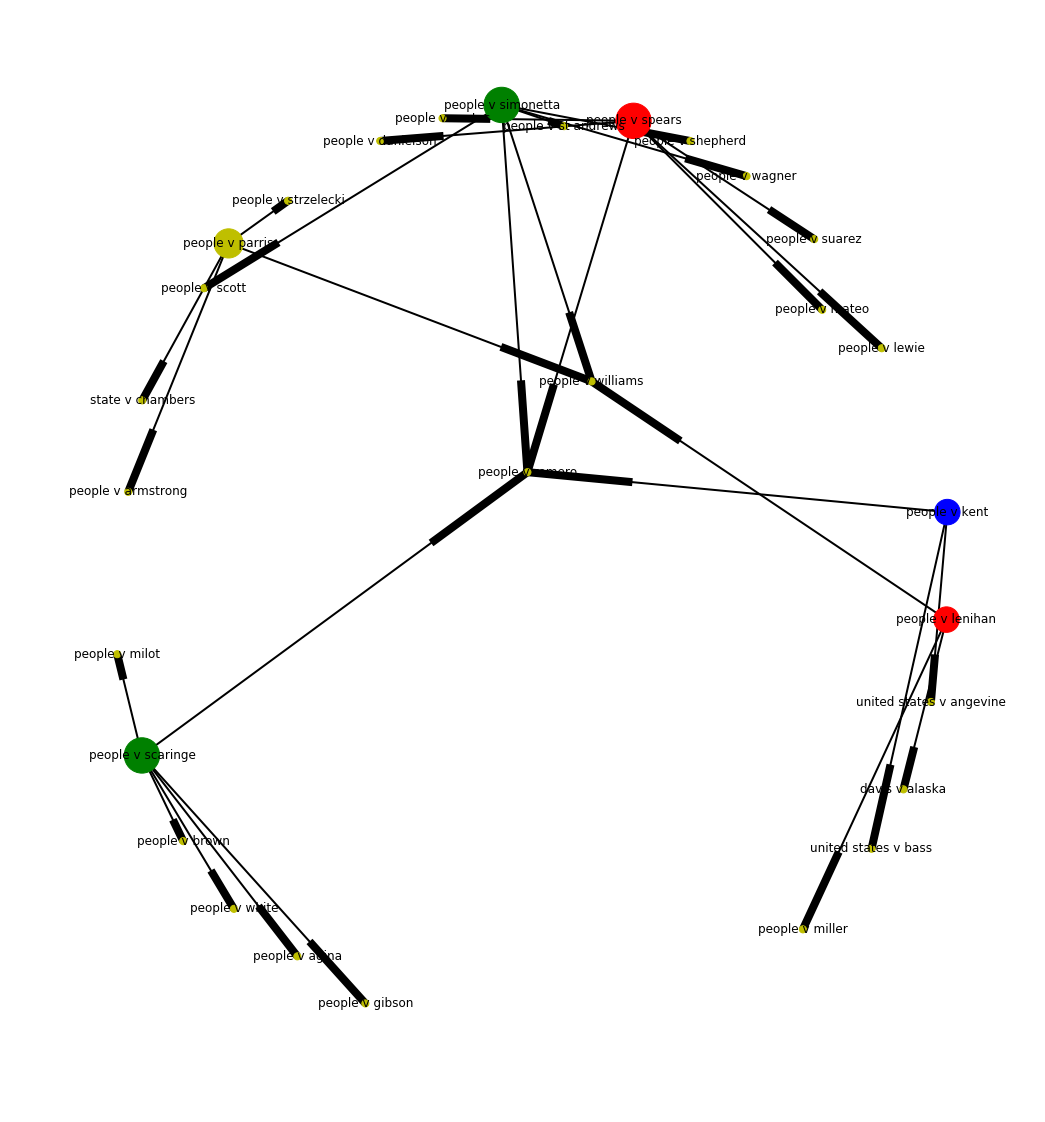

In [116]:
import matplotlib as mpl

print(df.loc[df['Case Name'].isin(subgraph.nodes()),['Case Name','Evidence Type']])
color_list=[]
for node in subgraph.nodes():
    c = df.loc[df['Case Name']==node,'Evidence Type']
    if len(c)==0:
        color_list.append('y')
    else:
        if c.iloc[0] in ["messaging (inbox)","messaging;messaging (inbox)"]:
            color_list.append('g')
        elif c.iloc[0] == "photographs":
            color_list.append('r')
        elif c.iloc[0] == "posts":
            color_list.append('b')
        else:
            print(c.iloc[0])

pos = nx.layout.spring_layout(subgraph)

in_degree = list(subgraph.out_degree(subgraph.nodes()).values())
node_sizes = [x*200+50 for x in in_degree]
# M = G.number_of_edges()
# edge_colors = list(range(2, M + 2))
# edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
fig, ax = plt.subplots(figsize=(18,20))
nodes = nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=color_list)
edges = nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color='k',
                               edge_cmap=plt.cm.Blues, width=2)
# edges = nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes, 
#                                arrows=True, edge_color='r', width=1)
labels=nx.draw_networkx_labels(subgraph,pos)

ax = plt.gca()
ax.set_axis_off()
plt.show()

             Case Name                Evidence Type
14       people v kent                        posts
25    people v lenihan                  photographs
30     people v spears                  photographs
31  people v simonetta            messaging (inbox)
32   people v scaringe  messaging;messaging (inbox)


//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


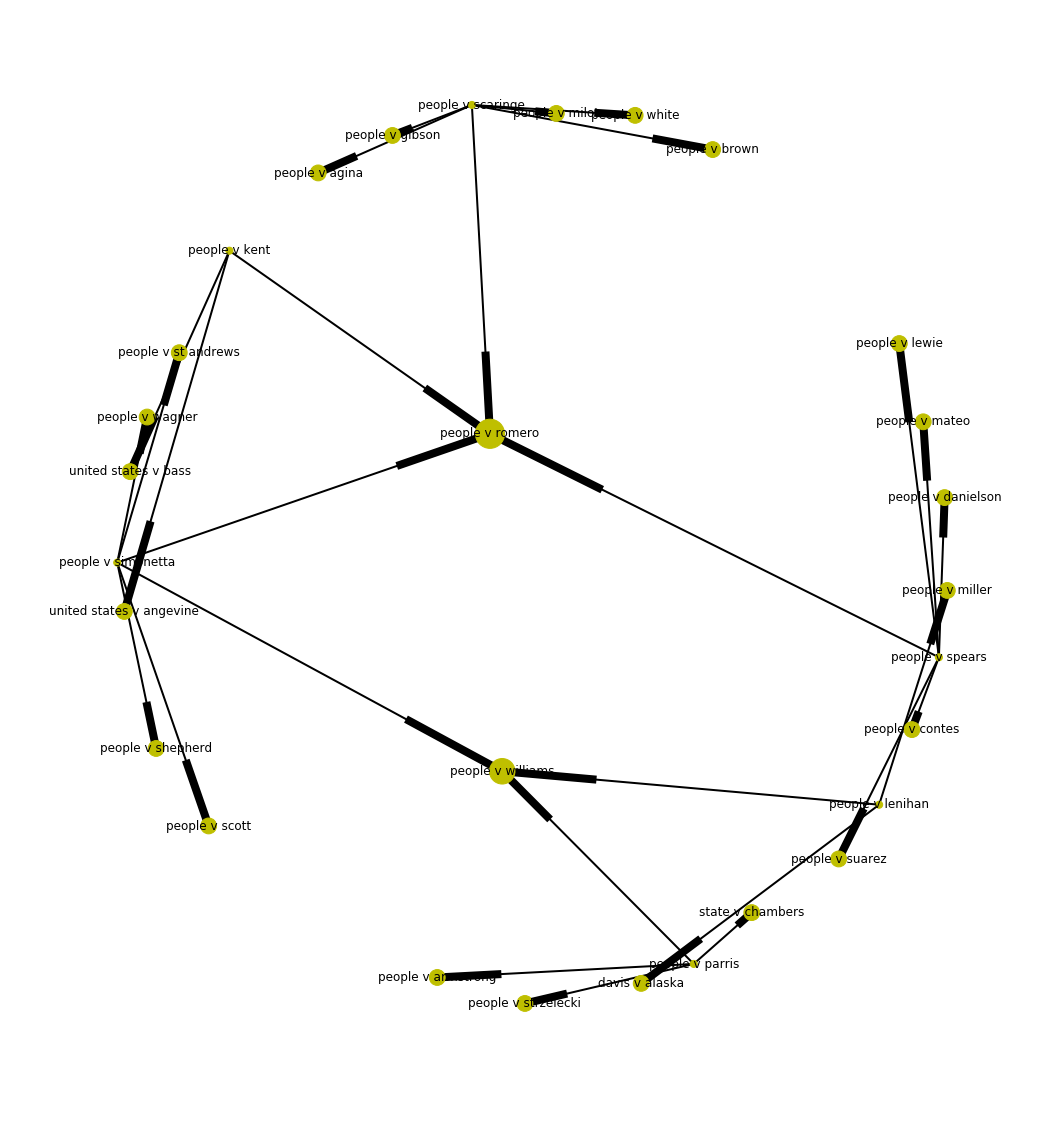

In [151]:
import matplotlib as mpl

print(df.loc[df['Case Name'].isin(subgraph.nodes()),['Case Name','Evidence Type']])
color_list=[]
for node in subgraph.nodes():
    c = df.loc[df['Case Name']==node,'Evidence Type']
    if len(c)==0:
        color_list.append('y')
    else:
        if c.iloc[0] in ["messaging (inbox)","messaging;messaging (inbox)"]:
            color_list.append('g')
        elif c.iloc[0] == "photographs":
            color_list.append('r')
        elif c.iloc[0] == "posts":
            color_list.append('b')
        else:
            print(c.iloc[0])

pos = nx.layout.spring_layout(subgraph)

in_degree = list(subgraph.in_degree(subgraph.nodes()).values())
node_sizes = [x*200+50 for x in in_degree]
# M = G.number_of_edges()
# edge_colors = list(range(2, M + 2))
# edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
fig, ax = plt.subplots(figsize=(18,20))
nodes = nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='y')#color_list
edges = nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color='k',
                               edge_cmap=plt.cm.Blues, width=2)
# edges = nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes, 
#                                arrows=True, edge_color='r', width=1)
labels=nx.draw_networkx_labels(subgraph,pos)
# set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

# pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
# pc.set_array(edge_colors)
# plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

## Connected components

In [21]:
# If your Graph has more than one component, this will return False:
undir=G.to_undirected()
print(nx.is_connected(undir))

# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(undir)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.
#

subgraph = undir.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

False
Network diameter of largest component: 6


In [22]:
sorted(nx.connected_components(undir), key=len)

[{'lorraine v markel', 'people v moye'},
 {'matter of acosta v new york city dept of education',
  'matter of tinsley v taxi'},
 {'pecile v titan capital group', 'tapp v new york state urban dev corp'},
 {'people v jackson', 'people v rose & people v valencia'},
 {'people v james', 'people v wright'},
 {'people v munck', 'people v tarsia'},
 {'people v rodriguez', 'people v wilson'},
 {'fawcett v altieri',
  'people v harris',
  "st paul's sch of nursing, inc v papaspiridakos"},
 {'matter of kellogg v ny s board of parole',
  'matter of silmon v travis',
  'phillips v dennison'},
 {'matton v us', 'people v de lucia', 'people v santana'},
 {'people v bonie', 'people v combest', 'people v mercereau'},
 {'people v corby', 'people v halter', 'people v hayes'},
 {'people v jamison', 'people v lara', 'people v richardson'},
 {'matter of colby',
  'people v agudelo',
  'people v mccommons',
  'people v shortell'},
 {'people v bigelow',
  'people v boddie',
  'people v mercado',
  'people v mo

//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure

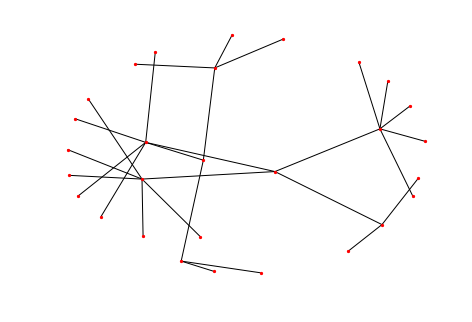

In [23]:
nx.draw_spring(subgraph, node_size=5,scale=2)

In [25]:
print(len(subgraph.nodes()))
subgraph.nodes()

29


['people v armstrong',
 'people v shepherd',
 'people v white',
 'people v mateo',
 'people v parris',
 'people v miller',
 'united states v bass',
 'people v simonetta',
 'people v st andrews',
 'people v scott',
 'people v strzelecki',
 'people v danielson',
 'people v spears',
 'people v contes',
 'people v scaringe',
 'people v williams',
 'people v gibson',
 'people v agina',
 'people v suarez',
 'people v romero',
 'people v lenihan',
 'people v kent',
 'people v lewie',
 'people v milot',
 'united states v angevine',
 'davis v alaska',
 'people v wagner',
 'state v chambers',
 'people v brown']